{'INV_0_0\n3.25': 3.25, 'INV_1_0\n1.0': 1.0, 'NAND_1_1\n2.0': 2.0}


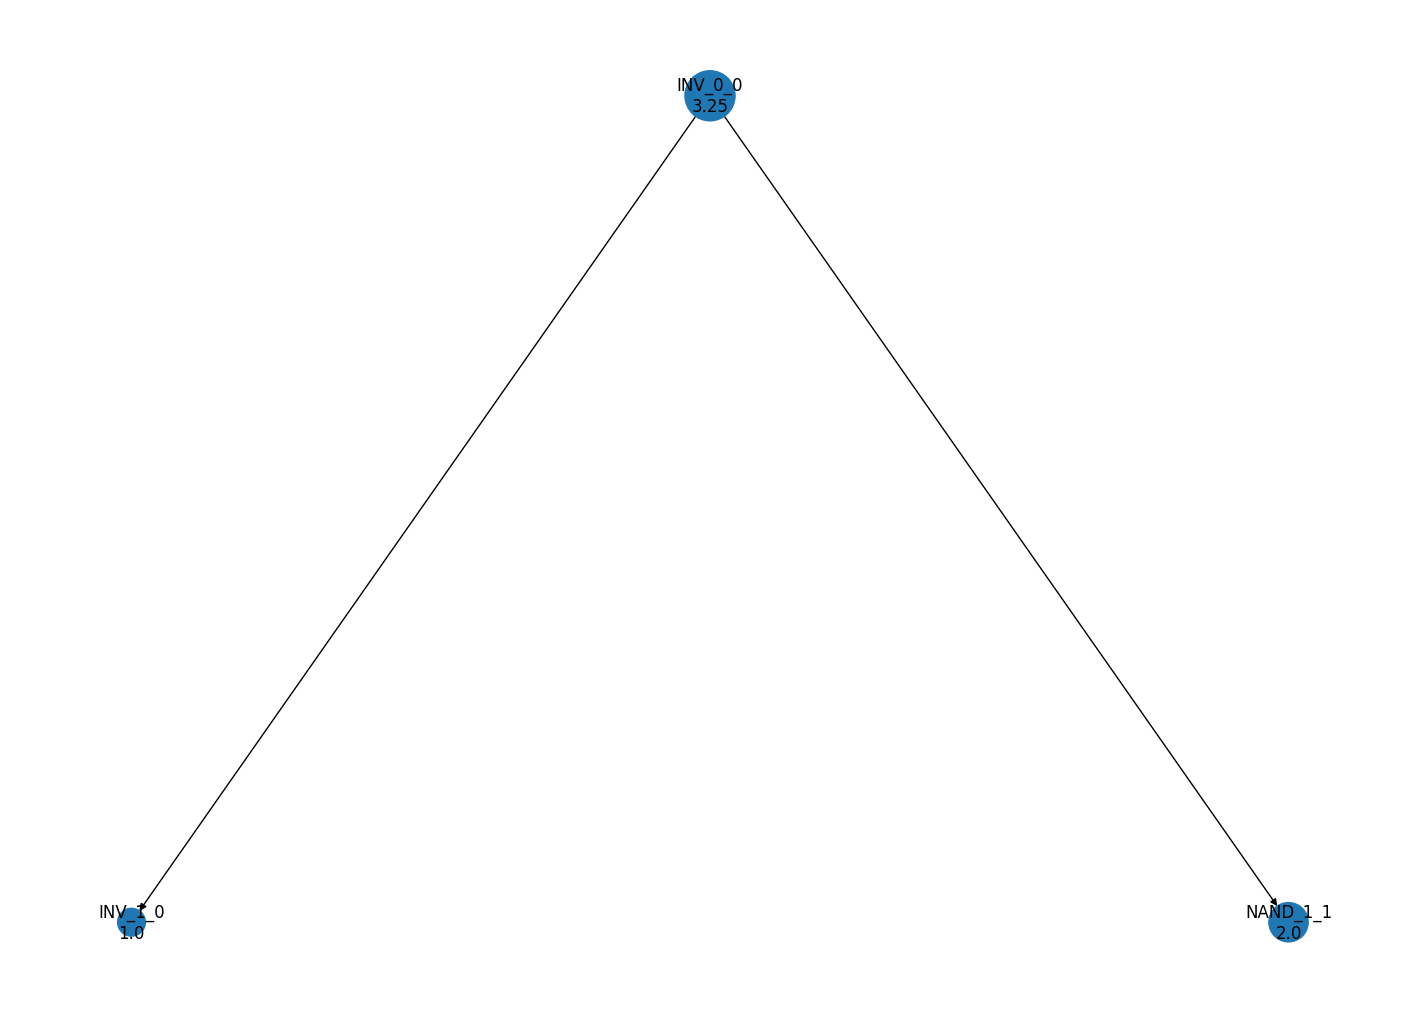

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from pylab import rcParams

class gate:
    def __init__(self,type):
        self.children = []
        self.type = type
        self.layer = 0
        self.number = 0
        if type == "INV":
            self.P = 1
            self.g = 1 
            self.Co = 4
            self.Ci = 4
        elif type == "NAND":
            self.P = 2
            self.g = 7/4
            self.Co = 8 
            self.Ci = 5 
        elif type == "3NAND":
            self.P = 3
            self.g = 10/4
            self.Co = 12
            self.Ci = 10
        self.wirecap = 0
    def generatename(self):
        self.name = self.type +"_" + str(self.layer) + "_" + str(self.number)

    def add_downstream(self, obj):
        self.children.append(obj)
    
    def calculate_delays(self):
        Cext = self.wirecap 
        for child in self.children:
            Cext+=child.Ci
        f = Cext/self.Co
        self.delay = self.P + self.g*f
        if (self.wirecap>0):
            self.name = self.name + "\n Cw = " + str(self.wirecap)
        self.name = self.name + "\n" + str(self.delay)
        for child in self.children:
            child.calculate_delays()

    
    def plotDelays(self, graph):
        graph.add_node(self.name,delay=self.delay)
        for child in self.children:
            graph.add_edge(self.name, child.name)
            child.plotDelays(graph)
        return graph
        

#Allow a user to input a tree structure
def fill_tree(obj):
    fanout = int(input("Enter fanout for {}".format(obj.type)))
    for i in range(fanout):
        child = gate(input("Enter gate type for gate #{}".format(i)))
        child.number = i
        child.layer = obj.layer + 1
        child.generatename()
        obj.add_downstream(child)
    for child in obj.children:
        child = fill_tree(child)
    return obj

root = gate("INV")
root.number = 0
root.layer = 0
root.generatename()
root = fill_tree(root)
root.calculate_delays()
graph = nx.DiGraph()
graph.add_node(root.name,delay=root.delay)
graph = root.plotDelays(graph)
delays =  nx.get_node_attributes(graph, 'delay')
magnitudes = [data['delay'] for _, data in graph.nodes(data=True)]
print(delays)

pos=graphviz_layout(graph, prog='dot')
nx.draw(graph, pos, with_labels=True,node_size=[v * 800 for v in magnitudes],arrows=True)
plt.show()

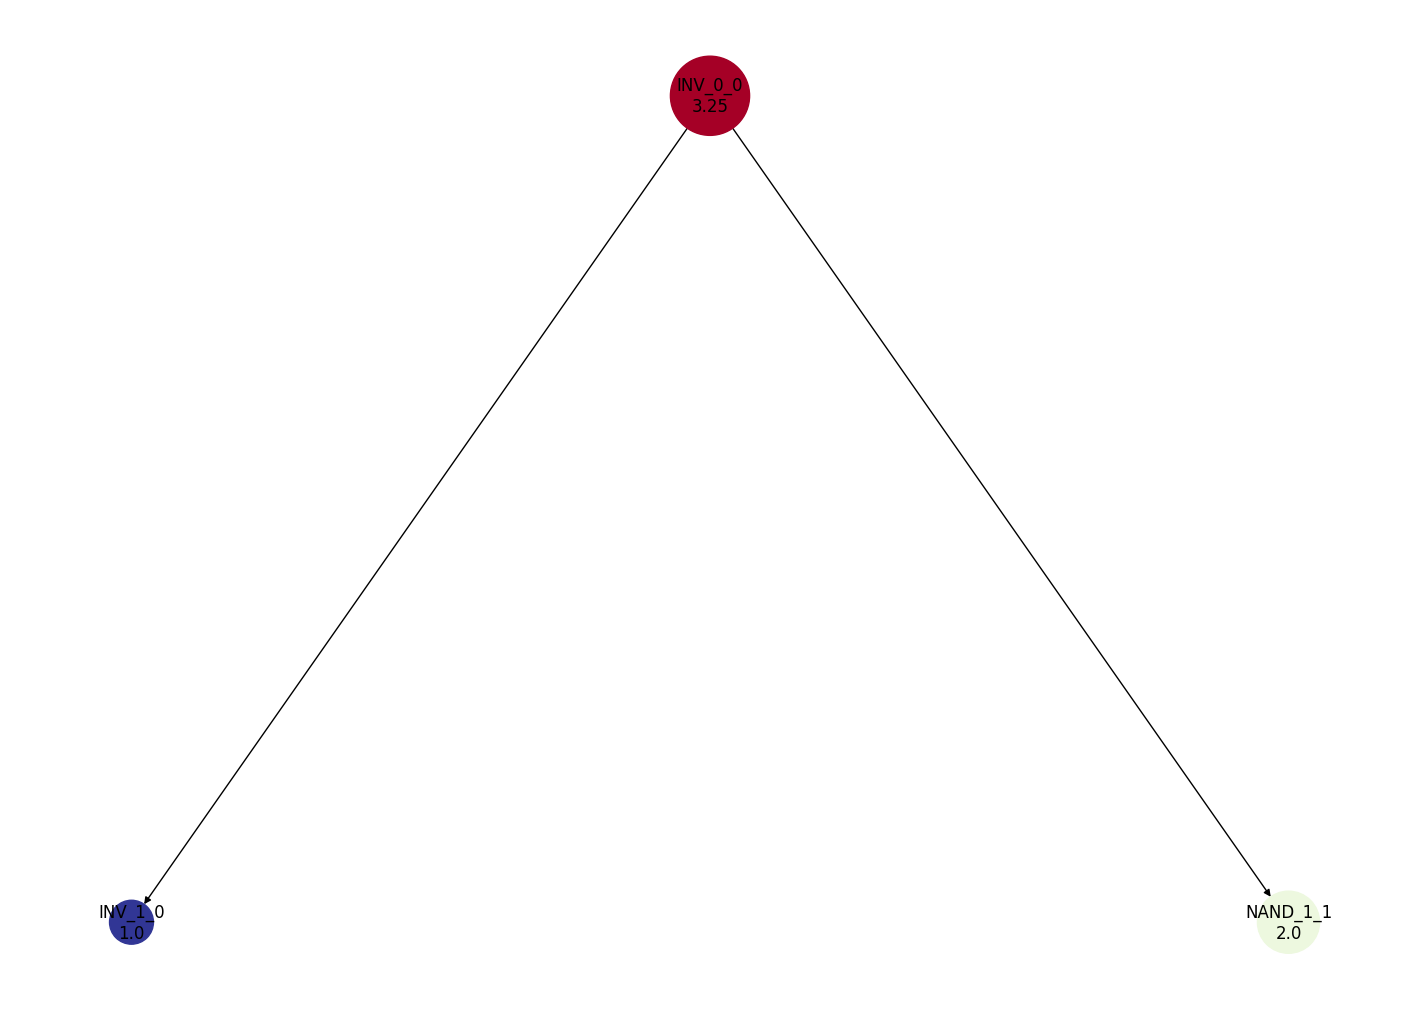

In [36]:
# Define the colormap (blue to red)
colormap = plt.colormaps.get_cmap('RdYlBu_r')  # You can choose other colormaps as well

# Normalize the magnitudes to the range [0, 1] to fit the colormap
norm_magnitudes = [(mag - min(magnitudes)) / (max(magnitudes) - min(magnitudes)) for mag in magnitudes]

pos=graphviz_layout(graph, prog='dot')
nx.draw(graph, pos, with_labels=True,node_size=[v * 1000 for v in magnitudes],arrows=True,node_color=norm_magnitudes, cmap=colormap)
plt.show()